# Image Captioning using Deep Learning

In [1]:
import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('tensorflow: %s' % tensorflow.__version__)
print('keras: %s' % keras.__version__)

tensorflow: 2.9.2
keras: 2.9.0


In [2]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Function to extract features from images using VGG19

In [4]:
from os import listdir
from pickle import dump
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model

def extract_features(address,filenames):
    model = VGG19()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict()
    for name in filenames:
        filename = address + name
        image = load_img(filename, target_size = (224,224))
        image = img_to_array(image)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        image = preprocess_input(image)
        feature = model.predict(image, verbose = 0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        #print('>%s' % name)
    return features
    
directory = '/content/drive/My Drive/flickr8k/'

### Splitting flickr8k image-caption dataset into 90% for training and 10% for testing

In [5]:
image_dataset = listdir(directory + 'images')

train_size = int(0.9*len(image_dataset))
test_size = len(image_dataset) - train_size
train_data = image_dataset[:train_size]
test_data = image_dataset[train_size:]

In [6]:
print("The number of jpg flies in Flicker8k: {}".format(len(image_dataset)))
print("The number of jpg flies in Train data: {}".format(len(train_data)))
print("The number of jpg flies in Test data: {}".format(len(test_data)))

The number of jpg flies in Flicker8k: 8091
The number of jpg flies in Train data: 7281
The number of jpg flies in Test data: 810


## Extracting features from train and test data images

In [7]:
train_features =  extract_features(directory + 'images/', train_data)
test_features = extract_features(directory + 'images/', test_data)

574710816/574710816 [==============================] - 19s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

### Storing the features of images into a pickle file ``features.pkl``

In [8]:
dump(train_features, open('/content/drive/My Drive/flickr8k/features.pkl','wb'))
#with open('/content/drive/My Drive/flickr8k/features.pkl', 'wb') as outfile:
#    dump(features, outfile)
#print('features stored in features.pkl file')

In [9]:
#import pickle
#features = None
#with open('/content/drive/My Drive/flickr8k/features.pkl', 'rb') as infile:
#    features = pickle.load(infile)
#print('features read from features.pkl file')

## Analysis of flickr8k dataset 

In [10]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/flickr8k/captions.txt')
df.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [12]:
from collections import Counter

unique_images = np.unique(df.image.values)
print("The number of unique image names : {}".format(len(unique_images)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df.image.values).values())

The number of unique image names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

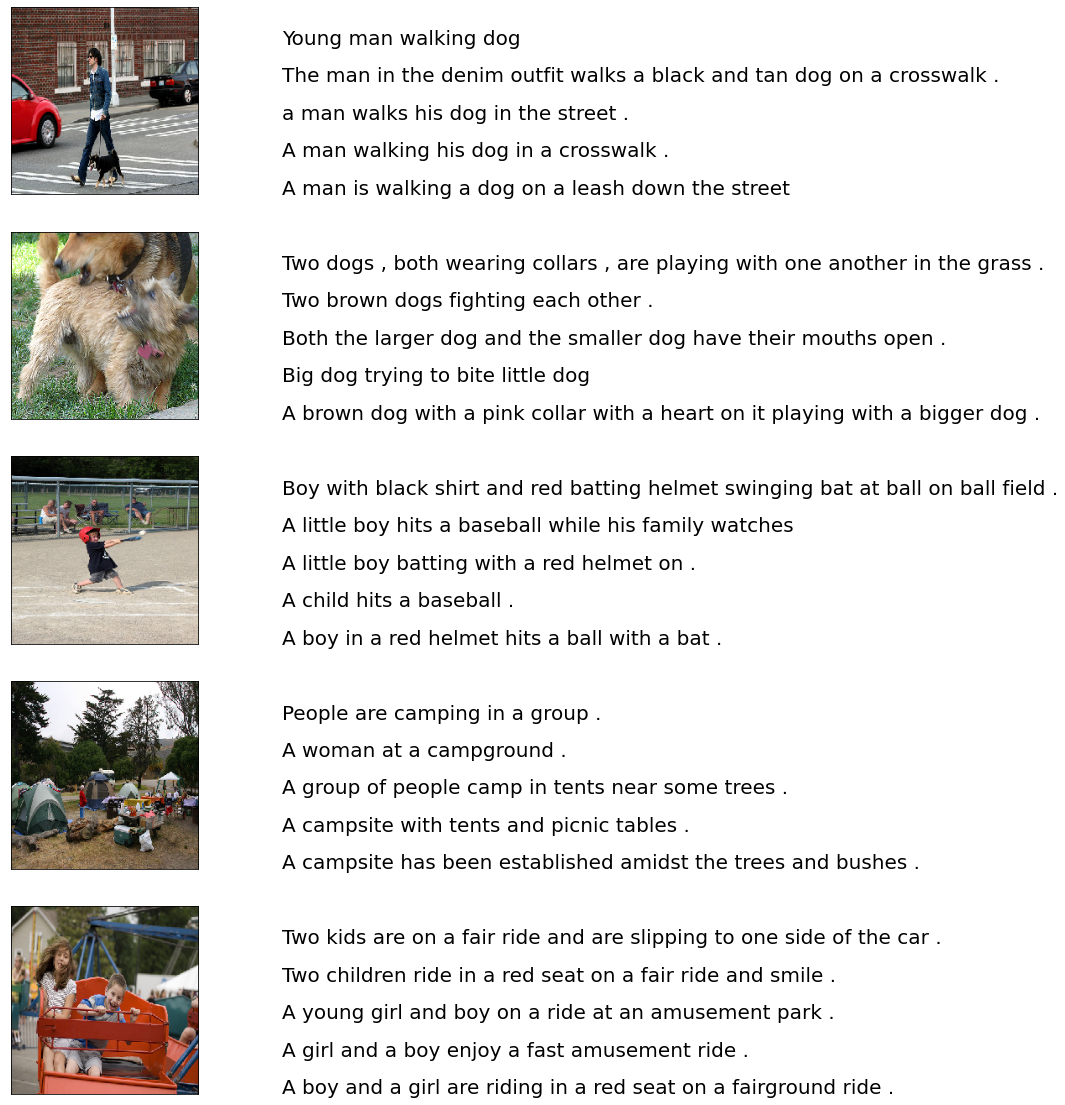

In [30]:
num_pic = 5
target_size = (224,224,3)

count = 1
fig = plt.figure(figsize=(10,20))
for img in unique_images[7669:7669+num_pic]:
    filename = directory + 'images/' + img
    captions = list(df["caption"].loc[df["image"]==img].values)
    image_load = load_img(filename, target_size=target_size)    
    ax = fig.add_subplot(num_pic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    ax = fig.add_subplot(num_pic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [33]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,1]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df)
dfword.head()

Vocabulary Size: 9630


,word,count
0,a,40319
1,.,36577
2,A,22667
3,in,18962
4,the,15328


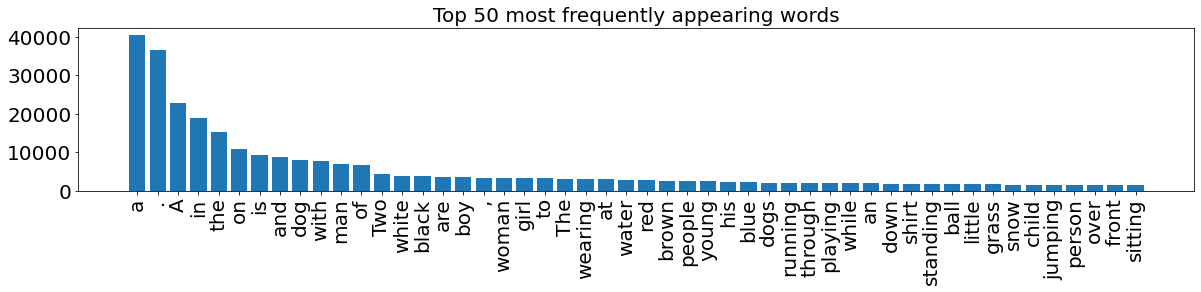

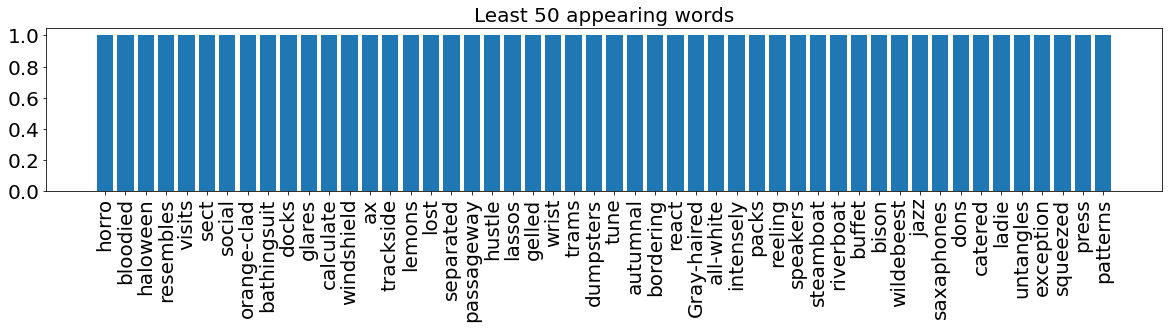

In [34]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="Top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="Least 50 appearing words")

## Pre-processing caption texts before passing into LSTM network

In [35]:
import string
import re

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    table = str.maketrans('','',string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [re.sub(r'[^\w\s]', '', w) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename = '/content/drive/My Drive/flickr8k/captions.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d' % len(descriptions))
clean_descriptions(descriptions)
voc = to_vocabulary(descriptions)
print('Vocabulary size: %d' % len(voc))
save_descriptions(descriptions, '/content/drive/My Drive/flickr8k/descriptions.txt')

Loaded: 8092
Vocabulary size: 8680


## Appending `startseq` and `endseq` keywords in the caption texts 

In [36]:
def modify_descriptions(img_names, img_descs):
    desc_dict = dict()
    for key, desc in img_descs.items():
        if key in img_names:
            modified_desc = list()
            for i in range(len(desc)):
                modified_desc.append('startseq ' + desc[i] + ' endseq')
            desc_dict[key] = modified_desc
    return desc_dict

train_image_names = [i.split('.')[0] for i in train_data]
test_image_names = [i.split('.')[0] for i in test_data]

train_descriptions = modify_descriptions(train_image_names, descriptions)    
test_descriptions = modify_descriptions(test_image_names, descriptions)

## Functions for processing sequence of features vectors of words

In [37]:
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import pad_sequences


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
  
def create_tokenizer(desc):
    lines = to_lines(desc)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

def max_length_function(desc):
    lines = to_lines(desc)
    return max(len(d.split()) for d in lines)

def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

Vocabulary Size: 8249


## Model Definition with layers after feature extraction using VGG19

In [38]:
def define_model(vocab_size, max_length):
    input1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(input1)
    fe2 = Dense(256, activation='relu')(fe1)
    input2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
    model = Model(inputs=[input1, input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    print(model.summary())
    return model

## Function to generate input data for model

In [39]:
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]

## Training the model and saving trained model

In [40]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

# Maximum number of words in a line or sentence
max_length = max_length_function(train_descriptions)

# Defining the final Model
model = define_model(vocab_size, max_length)

# train the model, run epochs manually and save after each epoch
epochs = 2
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)
    model.save(directory + 'model_final_' + str(i) + '.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 256)      2111744     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

## Model Evaluation using BLEU score of captions generated for test data

In [41]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen = max_length)
        yhat = model.predict([photo,sequence], verbose = 0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text
  
def evaluate_model(model, desc, photos, tokenizer, max_length):
    actual, pred = [], []
    for key, desc_list in desc.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        pred.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, pred, weights=(1.0,0,0,0)))
    print('BLEU-2: %f' % corpus_bleu(actual, pred, weights=(0.5,0.5,0,0)))
    print('BLEU-3: %f' % corpus_bleu(actual, pred, weights=(0.3,0.3,0.3,0)))
    print('BLEU-4: %f' % corpus_bleu(actual, pred, weights=(0.25,0.25,0.25,0.25)))

In [42]:
filename = directory + 'model_final_1.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.536268
BLEU-2: 0.292619
BLEU-3: 0.197386
BLEU-4: 0.087210


## Generating Captions for some images and comparing them with true caption

In [43]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
#from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg19 import VGG19
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# extract features from each photo in the directory

def extract_features_filename(filename):
		model = VGG19()
		model.layers.pop()
		model = Model(inputs=model.inputs, outputs = model.layers[-2].output)
		img = load_img(filename, target_size = (224,224))
		img = img_to_array(img)
		img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
		img = preprocess_input(img)
		feature = model.predict(img, verbose = 0)
		return feature	  

#max_length = 33
model = load_model(directory + 'model_final_1.h5')

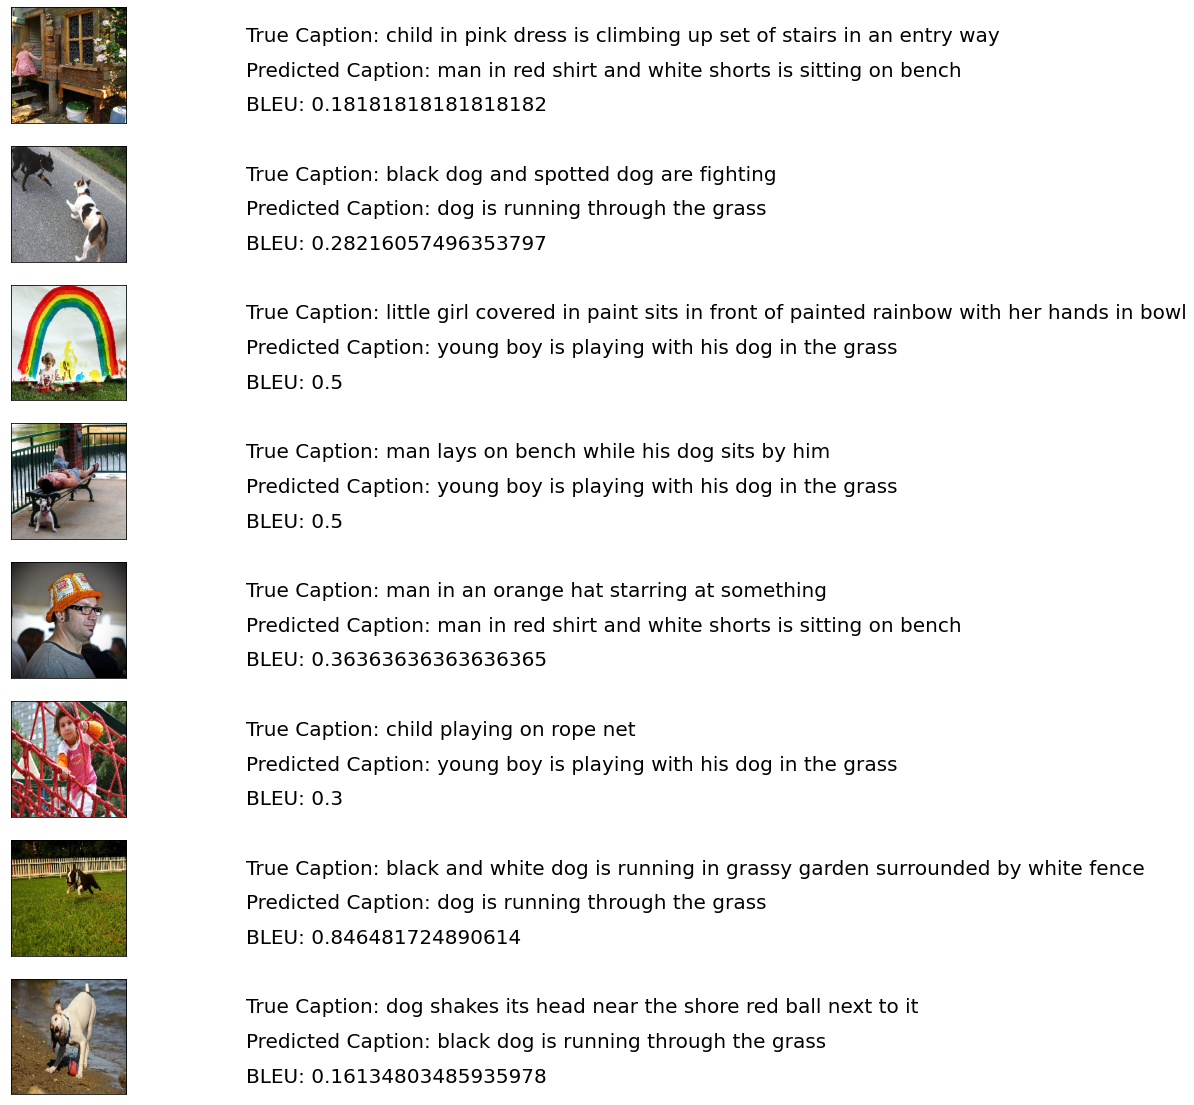

In [51]:
count = 1
fig = plt.figure(figsize=(10,20))
num_img = 8

for i in test_descriptions.keys():
		photo = extract_features_filename(directory + 'images/' + i + '.jpg')
		#plt.plot()
		img = load_img(directory + 'images/' + i + '.jpg', target_size = (224,224))
		#plt.imshow(img)
		description = generate_desc(model, tokenizer, photo, max_length)
		pred_desc = str(description).split()[1:-1]
		predicted_cap = ' '.join(pred_desc)
		ax = fig.add_subplot(num_img,2,count,xticks=[],yticks=[])
		ax.imshow(img)
		count += 1
		
		ax = fig.add_subplot(num_img, 2, count)
		plt.axis('off')
		ax.plot()
		ax.set_xlim(0,1)
		ax.set_ylim(0,1)
		true_one = str(test_descriptions[i][0]).split()[1:-1]
		true_cap = []
		for j in test_descriptions[i]:
				true_cap.append(j.split()[1:-1])
		bleu = sentence_bleu(true_cap,pred_desc,weights=(1,0,0,0))
		ax.text(0,0.7,"True Caption: " + ' '.join(true_one), fontsize = 20)
		ax.text(0,0.4,"Predicted Caption: " + predicted_cap, fontsize=20)
		ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
		count += 1
		if count == 2*num_img + 1:
				break
plt.show()

## Generating captions for some random images

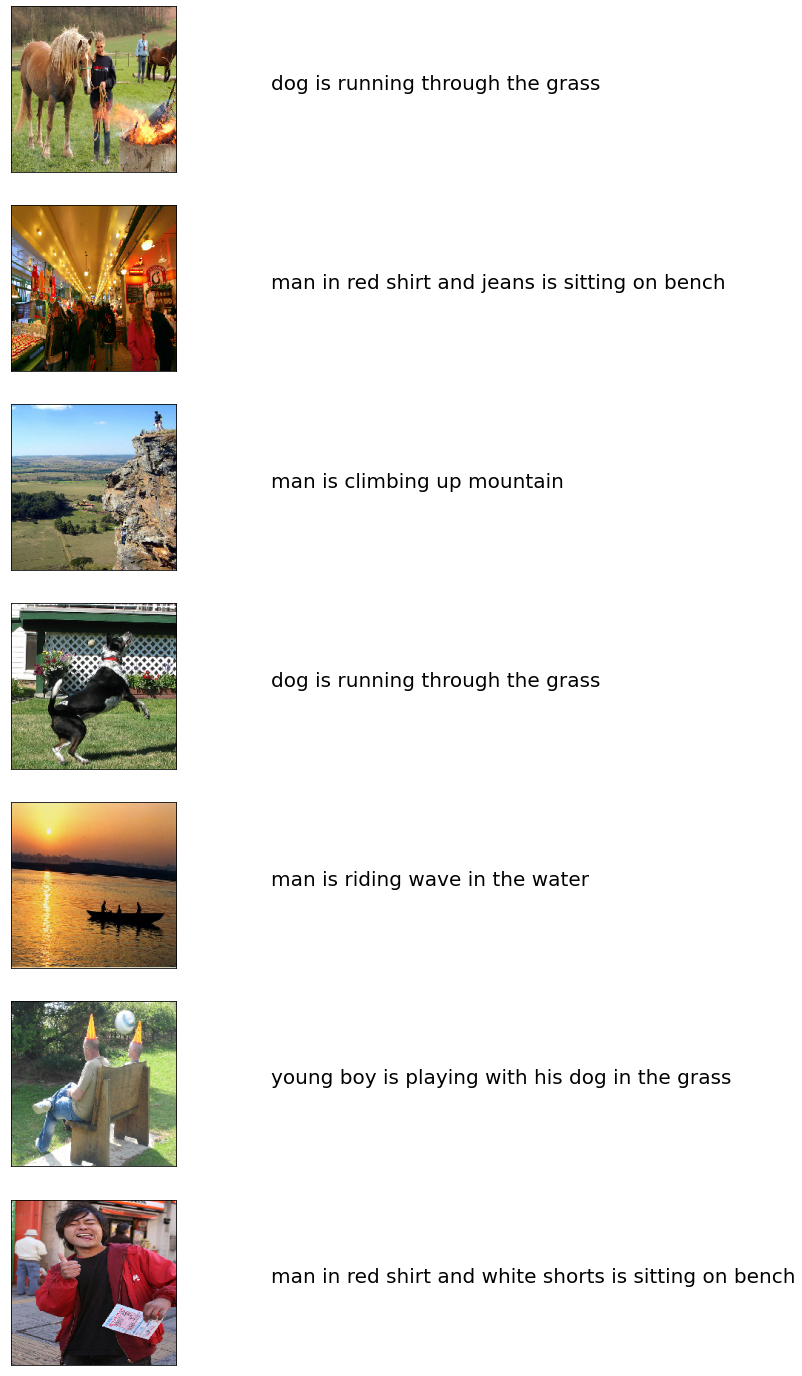

In [ ]:
random_test = []

for i in range(1,8):
    random_test.append('test' + str(i) + '.jpg')

count = 1
fig = plt.figure(figsize=(10,25))
n_img = len(random_test)

for i in random_test:
    photo = extract_features_filename(directory + i)
    img = load_img(directory + i, target_size = (224,224))
    ax = fig.add_subplot(n_img,2,count,xticks=[],yticks=[])
    ax.imshow(img)
    count += 1
    desc = generate_desc(model, tokenizer, photo, max_length)
    pred_desc = str(desc).split()[1:-1]
    cap_generated = ' '.join(pred_desc)
    ax = fig.add_subplot(n_img, 2, count)
    ax.plot()
    plt.axis('off')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,cap_generated,fontsize=20)
    count += 1

plt.show()